# Topical Analysis

This notebook extends the analysis done in Filippou et al. (2024) to a topical level.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

chunk_predictions = pd.read_csv("chunk_predictions.csv")
chunk_predictions = chunk_predictions.drop("Text", axis=1)
results_df = chunk_predictions

In [2]:
# Want to aggregate by month instead of quarter

# Step 1: Extract Year and Report Number
results_df["Year"] = results_df["Filename"].str.extract(r"(\d{4})").astype(int)
results_df["Report_Number"] = results_df["Filename"].str.extract(r"\((\d+)\)").astype(int)

# Step 2: Map Report Numbers to Months
    # Got months from Fed website and put them in a spreadsheet
    # See C:\Users\MCOB PHD 14\Desktop\bbFinal\Notebooks\BB_publication_months.xlsx
def get_month(year, report_number):
    # Define mappings for report numbers to months
    if 1970 <= year <= 1978:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "06", 8: "05", 9: "04", 
                         10: "03", 11: "02", 12: "01"}
    elif year == 1979:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "07", 6: "05", 7: "04", 8: "03", 9: "01"}
    elif year == 1980:
        month_mapping = {1: "12", 2: "11", 3: "10", 4: "09", 5: "08", 6: "07", 7: "05", 8: "04", 9: "03", 10: "01"}
    elif year in {1981, 2017, 2023}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year == 2012:
        month_mapping = {1: "11", 2: "10", 3: "08", 4: "07", 5: "06", 6: "04", 7: "02", 8: "01"}
    elif year in {2018, 2020, 2024}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "05", 6: "04", 7: "03", 8: "01"}
    elif year in {2002, 2003, 2005, 2006, 2007, 2011, 2016, 2019, 2022}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {2004, 2008, 2009, 2010, 2013, 2014, 2015, 2021}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "07", 5: "06", 6: "04", 7: "03", 8: "01"}
    elif year in {1988, 2001}:
        month_mapping = {1: "11", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    elif year == 1983:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "07", 6: "05", 7: "03", 8: "02"}
    elif year in {1984, 1985, 1986, 1987, 1990, 1991, 1996, 1997}:
        month_mapping = {1: "12", 2: "10", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    else:
        month_mapping = {1: "12", 2: "11", 3: "09", 4: "08", 5: "06", 6: "05", 7: "03", 8: "01"}
    return month_mapping.get(report_number, "Unknown")

results_df["Month"] = results_df.apply(lambda row: get_month(row["Year"], row["Report_Number"]), axis=1)

# Step 3: Convert Year and Month to Date-Time Format
results_df["DATE"] = results_df.apply(lambda row: f"{row['Year']}-{row['Month']}-01", axis=1)
results_df["DATE"] = pd.to_datetime(results_df["DATE"], errors="coerce")

# Step 4: Aggregate Data by Month
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

aggregated_df = results_df.groupby("DATE")[topic_columns].sum().reset_index()

# Export to csv
#aggregated_df.to_csv("aggregated_predictions_monthly.csv", index=False)

df = aggregated_df
df['DATE'] = pd.to_datetime(df['DATE'])

# Create dummy variable for dates of recessions
    # Dates defined by Business Cycle Dating Committee of the NBER
df["Recession"] = 0
df.loc[(df["DATE"] >= "1969-12-01") & (df["DATE"] <= "1970-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1973-11-01") & (df["DATE"] <= "1975-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1980-01-01") & (df["DATE"] <= "1980-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1981-07-01") & (df["DATE"] <= "1982-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1990-07-01") & (df["DATE"] <= "1991-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2001-03-01") & (df["DATE"] <= "2001-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2007-12-01") & (df["DATE"] <= "2009-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2020-02-01") & (df["DATE"] <= "2020-04-01"), "Recession"] = 1

# Topic columns
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]



In [5]:
# Check VIFs for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = (df[topic_columns])
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values("VIF", ascending=False)
print(vif)

# Lending and consumption both have VIFs greater than 5, so we will drop both
# Also dropped employment and prices

          Variable        VIF
5          Lending  10.210295
2      Consumption   9.288462
4     Construction   5.923758
0       Employment   5.890261
3    Manufacturing   5.474942
1           Prices   5.436210
10           Labor   4.963364
8   Transportation   3.900091
7        Resources   3.825221
6      Uncertainty   3.446500
11         Capital   3.300496
9          Outlook   2.980609
12           Trade   1.951134


In [6]:
df[topic_columns].describe()

,Employment,Prices,Consumption,Manufacturing,Construction,Lending,Uncertainty,Resources,Transportation,Outlook,Labor,Capital,Trade
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,5.651064,7.468085,12.289362,4.117021,9.646809,15.078723,4.561702,6.240426,3.270213,2.012766,7.593617,2.802128,2.676596
std,4.373007,5.939823,6.214133,4.295226,6.387850,5.117820,4.849485,3.297551,5.006751,2.551777,7.147752,2.533611,4.547977
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,8.000000,1.000000,5.000000,12.000000,1.000000,4.000000,0.000000,0.000000,3.000000,1.000000,0.000000
50%,5.000000,6.000000,12.000000,3.000000,8.000000,14.500000,3.000000,6.000000,2.000000,1.000000,5.000000,2.000000,1.000000
75%,8.000000,10.000000,17.000000,6.000000,13.000000,18.000000,6.000000,8.000000,4.000000,3.000000,10.000000,4.000000,3.000000
max,26.000000,38.000000,32.000000,23.000000,30.000000,32.000000,32.000000,25.000000,36.000000,16.000000,43.000000,12.000000,30.000000


In [7]:
topic_columns = ["Employment", "Prices", "Manufacturing", "Construction",
                 "Uncertainty", "Resources", "Transportation", "Outlook",
                 "Labor", "Capital", "Trade"]

X = (df[topic_columns])
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.sort_values("VIF", ascending=False)
print(vif)

          Variable       VIF
0       Employment  5.558650
1           Prices  5.238183
8            Labor  4.707350
2    Manufacturing  4.597238
3     Construction  3.779543
6   Transportation  3.707350
4      Uncertainty  3.434930
5        Resources  3.352829
9          Capital  3.213317
7          Outlook  2.835685
10           Trade  1.908978


# Using topical counts to forecast recessions

In [8]:
# This is the same approach as Table 1, column 4 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# Logit model where 1 = economy in a recession, as defined by NBER

import statsmodels.api as sm

# Define X as including all the topic columns
X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.206722
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Recession   No. Observations:                  470
Model:                          Logit   Df Residuals:                      458
Method:                           MLE   Df Model:                           11
Date:                Fri, 07 Feb 2025   Pseudo R-squ.:                  0.4905
Time:                        14:59:36   Log-Likelihood:                -97.159
converged:                       True   LL-Null:                       -190.70
Covariance Type:            nonrobust   LLR p-value:                 3.543e-34
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -9.5594      1.215     -7.870      0.000     -11.940      -7.179
Employment         0.3668      0.070      5.275      0.000       0.231       0.503
Prices             0.2315      0.060      3.856      0.000       0.114       0.349
Manufacturing      0.0813      0.055      1.466      0.143      -0.027       0.190
Construction       0.1056      0.037      2.862      0.004       0.033       0.178
Uncertainty       -0.3023      0.092     -3.292      0.001      -0.482      -0.122
Resources          0.1938      0.053      3.635      0.000       0.089       0.298
Transportation    -0.2493      0.103     -2.431      0.015      -0.450      -0.048
Outlook            0.3260      0.095      3.447      0.001       0.141       0.511
Labor              0.0296      0.052      0.572      0.567      -0.072       0.131
Capital            0.2243      0.089      2.523      0.012       0.050       0.399
Trade              0.1781      0.064      2.764      0.006       0.052       0.304
==================================================================================
"""

In [9]:
# This is the same approach as Table 1, column 4 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# But probit instead

# Define X as including all the topic columns
X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.207249
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              Recession   No. Observations:                  470
Model:                         Probit   Df Residuals:                      458
Method:                           MLE   Df Model:                           11
Date:                Fri, 07 Feb 2025   Pseudo R-squ.:                  0.4892
Time:                        14:59:40   Log-Likelihood:                -97.407
converged:                       True   LL-Null:                       -190.70
Covariance Type:            nonrobust   LLR p-value:                 4.487e-34
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.0802      0.592     -8.580      0.000      -6.241      -3.920
Employment         0.1989      0.037      5.383      0.000       0.126       0.271
Prices             0.1263      0.031      4.011      0.000       0.065       0.188
Manufacturing      0.0464      0.030      1.531      0.126      -0.013       0.106
Construction       0.0484      0.019      2.584      0.010       0.012       0.085
Uncertainty       -0.1651      0.050     -3.316      0.001      -0.263      -0.068
Resources          0.0980      0.028      3.516      0.000       0.043       0.153
Transportation    -0.1119      0.052     -2.146      0.032      -0.214      -0.010
Outlook            0.1809      0.052      3.481      0.000       0.079       0.283
Labor              0.0070      0.026      0.265      0.791      -0.045       0.059
Capital            0.1184      0.046      2.567      0.010       0.028       0.209
Trade              0.0998      0.033      3.038      0.002       0.035       0.164
==================================================================================
"""

In [10]:
# Marginal effects from probit model
marginal_effects = model.get_margeff()
marginal_effects.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:              Recession
Method:                          dydx
At:                           overall
==================================================================================
                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Employment         0.0227      0.004      5.850      0.000       0.015       0.030
Prices             0.0144      0.003      4.181      0.000       0.008       0.021
Manufacturing      0.0053      0.003      1.544      0.123      -0.001       0.012
Construction       0.0055      0.002      2.587      0.010       0.001       0.010
Uncertainty       -0.0188      0.006     -3.415      0.001      -0.030      -0.008
Resources          0.0112      0.003      3.584      0.000       0.005       0.017
Transportation    -0.0128      0.006     -2.146      0.032      -0.024      -0.001
Outlook            0.0206      0.006      3.614      0.000       0.009       0.032
Labor              0.0008      0.003      0.264      0.791      -0.005       0.007
Capital            0.0135      0.005      2.605      0.009       0.003       0.024
Trade              0.0114      0.004      3.110      0.002       0.004       0.019
==================================================================================
"""

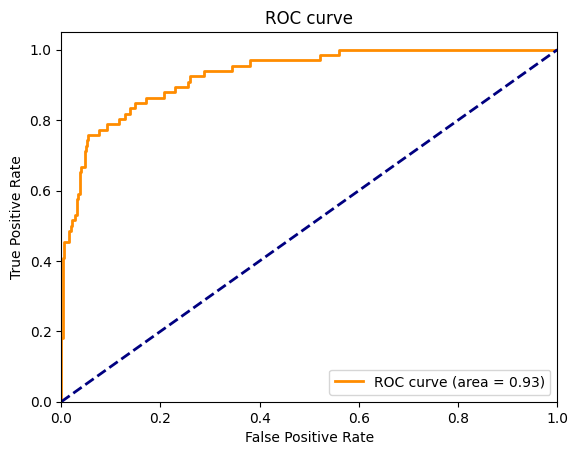

In [11]:
# ROC curve for probit model
from sklearn.metrics import roc_curve, roc_auc_score
y_pred = model.predict(X)
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Test for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Prepare the independent variables (X)
X = df[topic_columns]
X = sm.add_constant(X)

# Step 2: Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF results
vif_data

,Variable,VIF
0,const,20.079265
1,Employment,2.547709
2,Prices,2.519236
3,Manufacturing,2.425489
4,Construction,1.377970
5,Uncertainty,1.844641
6,Resources,1.080347
7,Transportation,2.835955
8,Outlook,1.823079
9,Labor,2.675656


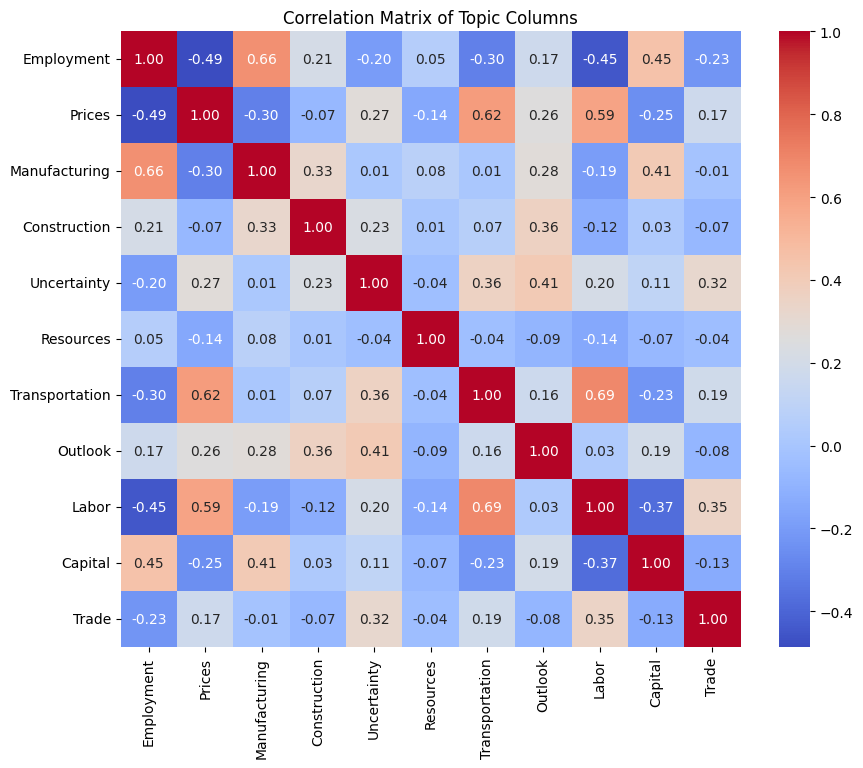

,Employment,Prices,Manufacturing,Construction,Uncertainty,Resources,Transportation,Outlook,Labor,Capital,Trade
Employment,1.000000,-0.487205,0.657512,0.209378,-0.200772,0.053737,-0.302349,0.172941,-0.448351,0.449273,-0.227393
Prices,-0.487205,1.000000,-0.303684,-0.074307,0.274651,-0.144770,0.620716,0.261538,0.593078,-0.252685,0.174839
Manufacturing,0.657512,-0.303684,1.000000,0.325490,0.012806,0.079903,0.009829,0.279605,-0.193671,0.409471,-0.011375
Construction,0.209378,-0.074307,0.325490,1.000000,0.231629,0.005862,0.067258,0.363527,-0.124706,0.026237,-0.071682
Uncertainty,-0.200772,0.274651,0.012806,0.231629,1.000000,-0.036063,0.360018,0.412081,0.204361,0.109370,0.319740
Resources,0.053737,-0.144770,0.079903,0.005862,-0.036063,1.000000,-0.038038,-0.088799,-0.144837,-0.069580,-0.044991
Transportation,-0.302349,0.620716,0.009829,0.067258,0.360018,-0.038038,1.000000,0.164783,0.687294,-0.227230,0.186534
Outlook,0.172941,0.261538,0.279605,0.363527,0.412081,-0.088799,0.164783,1.000000,0.033017,0.193981,-0.084524
Labor,-0.448351,0.593078,-0.193671,-0.124706,0.204361,-0.144837,0.687294,0.033017,1.000000,-0.372500,0.347381
Capital,0.449273,-0.252685,0.409471,0.026237,0.109370,-0.069580,-0.227230,0.193981,-0.372500,1.000000,-0.133614


In [13]:
# Correlation matrix of topic columns
corr = df[topic_columns].corr()

# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Topic Columns")
plt.show()

corr

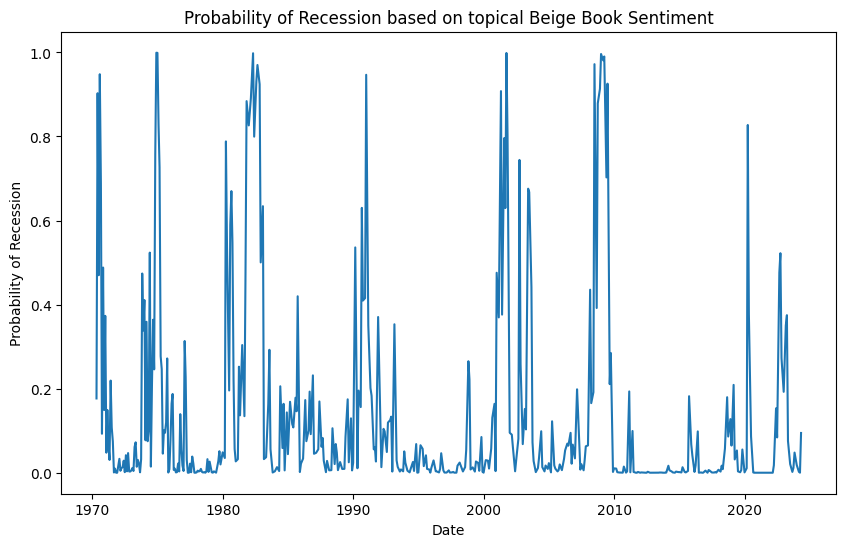

In [14]:
# This recreates Figure 2 from Filippou et al. (2024)
    # Clearly, sentiment from Beige Books is useful for predicting recessions
    # But also want to do this with the leads to see probability of a recession 3 mohths and 6 months out

# Calculate probabilities from the logit model above
df['Recession_probability'] = model.predict(X)

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Recession_probability'])
plt.xlabel('Date')
plt.ylabel('Probability of Recession')
plt.title('Probability of Recession based on topical Beige Book Sentiment')
plt.show()


# Lasso and ridge regressions

In [12]:
# Run lasso regression to select the most important topics
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Define X and y
X = df[topic_columns]
y = df['Recession']

# Standardize the independent variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Fit a Lasso regression model
model = LassoCV(cv=5)
model.fit(X, y)

# Get the coefficients
coefficients = model.coef_

# Get the most important topics
important_topics = [topic for i, topic in enumerate(topic_columns) if coefficients[i] != 0]
important_topics

['Employment', 'Manufacturing', 'Outlook', 'Capital']

In [15]:
# Try model with just the important topics
X = df[important_topics]
X = sm.add_constant(X)
y = df['Recession']

# Fit a logit model
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.250949
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Recession   No. Observations:                  470
Model:                          Logit   Df Residuals:                      465
Method:                           MLE   Df Model:                            4
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.3815
Time:                        17:01:32   Log-Likelihood:                -117.95
converged:                       True   LL-Null:                       -190.70
Covariance Type:            nonrobust   LLR p-value:                 1.875e-30
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -5.2291      0.476    -10.995      0.000      -6.161      -4.297
Employment        0.2756      0.053      5.169      0.000       0.171       0.380
Manufacturing     0.0622      0.044      1.423      0.155      -0.023       0.148
Outlook           0.2330      0.059      3.940      0.000       0.117       0.349
Capital           0.1162      0.069      1.681      0.093      -0.019       0.252
=================================================================================
"""

In [20]:
# Try ridge regression
from sklearn.linear_model import RidgeCV

X = df[topic_columns]
X = sm.add_constant(X)
y = df['Recession']

# Standardize the independent variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Fit a Ridge regression model
model = RidgeCV(cv=5)
model.fit(X, y)

# Get the coefficients
coefficients = model.coef_

# Match each coefficient to its corresponding topic and round to two decimal places
coefficients = {topic: round(coef, 2) for topic, coef in zip(topic_columns, coefficients)}

# Display the coefficients sorted by importance
coefficients = dict(sorted(coefficients.items(), key=lambda item: abs(item[1]), reverse=True))
coefficients

{'Prices': 0.14,
 'Consumption': 0.08,
 'Construction': 0.05,
 'Resources': -0.05,
 'Labor': 0.05,
 'Trade': 0.05,
 'Outlook': -0.04,
 'Transportation': 0.03,
 'Capital': 0.03,
 'Lending': 0.02,
 'Manufacturing': 0.01,
 'Employment': 0.0,
 'Uncertainty': 0.0}

# Lags of topical sentiment to predict recessions

This follows Filippou et al., 2024

In [6]:
# Create lags of dependent variable

# Create a three-period lead of the Recession dummy variable
df['Recession_lead_3'] = df['Recession'].shift(3)

# Create a six-period lead of the Recession dummy variable
df['Recession_lead_6'] = df['Recession'].shift(6)

# Create an eight-period lead of the Recession dummy variable
    # In Beige Books, this is a year ahead
df['Recession_lead_8'] = df['Recession'].shift(8)

# Create 16-period lead of the Recession dummy variable
    # In Beige Books, this is two years ahead
df['Recession_lead_16'] = df['Recession'].shift(16) 

# Create a three-month lag of the Recession dummy variable
df['Recession_lag_3'] = df['Recession'].shift(-3)

# Create a six-month lag of the Recession dummy variable
df['Recession_lag_6'] = df['Recession'].shift(-6)

In [63]:
# This is the same approach as Table 1, column 2 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the six-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_6']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.313367
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_6   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.1842
Time:                        21:01:23   Log-Likelihood:                -143.52
converged:                       True   LL-Null:                       -175.94
Covariance Type:            nonrobust   LLR p-value:                 7.086e-09
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.3312      1.147     -4.649      0.000      -7.579      -3.084
Employment        -0.2006      0.065     -3.097      0.002      -0.328      -0.074
Prices             0.1180      0.046      2.570      0.010       0.028       0.208
Consumption        0.0550      0.038      1.459      0.145      -0.019       0.129
Manufacturing      0.0863      0.059      1.473      0.141      -0.029       0.201
Construction       0.0785      0.030      2.599      0.009       0.019       0.138
Lending            0.0694      0.040      1.733      0.083      -0.009       0.148
Uncertainty       -0.2441      0.069     -3.518      0.000      -0.380      -0.108
Resources          0.2203      0.048      4.561      0.000       0.126       0.315
Transportation    -0.1458      0.073     -1.996      0.046      -0.289      -0.003
Outlook            0.1007      0.092      1.097      0.273      -0.079       0.281
Labor             -0.0297      0.039     -0.759      0.448      -0.106       0.047
Capital            0.0603      0.078      0.774      0.439      -0.092       0.213
Trade              0.0920      0.049      1.866      0.062      -0.005       0.189
==================================================================================
"""

In [9]:
# This is the same approach as Table 1, column 2 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# But Probit instead of logit

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the six-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_6']

# Fit Probit
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.319251
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_6   No. Observations:                  448
Model:                         Probit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.1806
Time:                        20:41:23   Log-Likelihood:                -143.02
converged:                       True   LL-Null:                       -174.54
Covariance Type:            nonrobust   LLR p-value:                 1.498e-08
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.9588      0.612     -4.835      0.000      -4.158      -1.759
Employment        -0.1129      0.035     -3.190      0.001      -0.182      -0.044
Prices             0.0646      0.025      2.578      0.010       0.015       0.114
Consumption        0.0311      0.020      1.530      0.126      -0.009       0.071
Manufacturing      0.0510      0.032      1.589      0.112      -0.012       0.114
Construction       0.0436      0.017      2.574      0.010       0.010       0.077
Lending            0.0347      0.022      1.580      0.114      -0.008       0.078
Uncertainty       -0.1291      0.036     -3.576      0.000      -0.200      -0.058
Resources          0.1199      0.026      4.558      0.000       0.068       0.171
Transportation    -0.0821      0.039     -2.099      0.036      -0.159      -0.005
Outlook            0.0531      0.051      1.050      0.294      -0.046       0.152
Labor             -0.0172      0.021     -0.804      0.422      -0.059       0.025
Capital            0.0361      0.043      0.839      0.401      -0.048       0.120
Trade              0.0578      0.025      2.352      0.019       0.010       0.106
==================================================================================
"""

In [64]:
# This is the same approach as Table 1, column 3 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Run the regression
import statsmodels.api as sm

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_3']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.293631
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_3   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.2356
Time:                        21:01:25   Log-Likelihood:                -134.48
converged:                       True   LL-Null:                       -175.94
Covariance Type:            nonrobust   LLR p-value:                 3.124e-12
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.2169      1.244     -5.802      0.000      -9.655      -4.779
Employment         0.0023      0.053      0.044      0.965      -0.101       0.105
Prices             0.1578      0.049      3.210      0.001       0.061       0.254
Consumption        0.0353      0.041      0.858      0.391      -0.045       0.116
Manufacturing      0.1055      0.058      1.829      0.067      -0.008       0.219
Construction       0.0684      0.034      2.026      0.043       0.002       0.134
Lending            0.0827      0.042      1.968      0.049       0.000       0.165
Uncertainty       -0.1586      0.065     -2.431      0.015      -0.286      -0.031
Resources          0.2014      0.050      4.004      0.000       0.103       0.300
Transportation    -0.2748      0.092     -2.988      0.003      -0.455      -0.095
Outlook            0.1819      0.091      2.000      0.045       0.004       0.360
Labor              0.0005      0.044      0.011      0.991      -0.086       0.087
Capital            0.0724      0.076      0.957      0.339      -0.076       0.221
Trade              0.1238      0.051      2.440      0.015       0.024       0.223
==================================================================================
"""

In [10]:
# This is the same approach as Table 1, column 3 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# Probit

# Run the regression
import statsmodels.api as sm

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lag of the Recession dummy variable
y = dfBinary['Recession_lag_3']

# Fit Probit
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.297130
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:        Recession_lag_3   No. Observations:                  448
Model:                         Probit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.2373
Time:                        20:46:15   Log-Likelihood:                -133.11
converged:                       True   LL-Null:                       -174.54
Covariance Type:            nonrobust   LLR p-value:                 3.197e-12
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.9916      0.662     -6.031      0.000      -5.289      -2.694
Employment         0.0036      0.030      0.118      0.906      -0.056       0.063
Prices             0.0832      0.027      3.100      0.002       0.031       0.136
Consumption        0.0218      0.022      0.985      0.324      -0.022       0.065
Manufacturing      0.0546      0.032      1.698      0.089      -0.008       0.118
Construction       0.0328      0.018      1.782      0.075      -0.003       0.069
Lending            0.0449      0.023      1.969      0.049       0.000       0.090
Uncertainty       -0.0873      0.034     -2.544      0.011      -0.155      -0.020
Resources          0.1060      0.027      3.861      0.000       0.052       0.160
Transportation    -0.1455      0.046     -3.153      0.002      -0.236      -0.055
Outlook            0.1105      0.050      2.207      0.027       0.012       0.209
Labor              0.0032      0.024      0.136      0.892      -0.044       0.050
Capital            0.0457      0.042      1.092      0.275      -0.036       0.128
Trade              0.0689      0.026      2.608      0.009       0.017       0.121
==================================================================================
"""

In [65]:
# This is the same approach as Table 1, column 5 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_3']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.207401
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_3   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.4821
Time:                        21:01:33   Log-Likelihood:                -94.990
converged:                       True   LL-Null:                       -183.43
Covariance Type:            nonrobust   LLR p-value:                 7.350e-31
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -7.9253      1.460     -5.429      0.000     -10.786      -5.064
Employment         0.3747      0.075      5.018      0.000       0.228       0.521
Prices             0.2252      0.065      3.443      0.001       0.097       0.353
Consumption        0.0051      0.049      0.105      0.917      -0.090       0.101
Manufacturing      0.0703      0.067      1.050      0.294      -0.061       0.202
Construction       0.0346      0.042      0.815      0.415      -0.049       0.118
Lending            0.0365      0.051      0.715      0.475      -0.064       0.136
Uncertainty       -0.0229      0.075     -0.304      0.761      -0.171       0.125
Resources          0.0838      0.056      1.507      0.132      -0.025       0.193
Transportation    -0.2290      0.111     -2.057      0.040      -0.447      -0.011
Outlook            0.1525      0.112      1.356      0.175      -0.068       0.373
Labor             -0.0481      0.065     -0.742      0.458      -0.175       0.079
Capital            0.1937      0.086      2.241      0.025       0.024       0.363
Trade             -0.2778      0.142     -1.952      0.051      -0.557       0.001
==================================================================================
"""

In [11]:
# This is the same approach as Table 1, column 5 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment
# Probit
# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 3-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_3']

# Fit the model with a logistic regression
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.195113
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_3   No. Observations:                  448
Model:                         Probit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.4992
Time:                        20:46:50   Log-Likelihood:                -87.411
converged:                       True   LL-Null:                       -174.54
Covariance Type:            nonrobust   LLR p-value:                 2.511e-30
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -4.5479      0.816     -5.574      0.000      -6.147      -2.949
Employment         0.1954      0.042      4.689      0.000       0.114       0.277
Prices             0.1145      0.036      3.180      0.001       0.044       0.185
Consumption       -0.0073      0.027     -0.267      0.789      -0.061       0.046
Manufacturing      0.0401      0.038      1.045      0.296      -0.035       0.115
Construction       0.0184      0.023      0.794      0.427      -0.027       0.064
Lending            0.0288      0.028      1.040      0.299      -0.025       0.083
Uncertainty       -0.0211      0.039     -0.545      0.585      -0.097       0.055
Resources          0.0695      0.031      2.238      0.025       0.009       0.130
Transportation    -0.0800      0.059     -1.361      0.173      -0.195       0.035
Outlook            0.1112      0.063      1.757      0.079      -0.013       0.235
Labor             -0.0500      0.040     -1.235      0.217      -0.129       0.029
Capital            0.1147      0.048      2.391      0.017       0.021       0.209
Trade             -0.1144      0.069     -1.647      0.100      -0.250       0.022
==================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

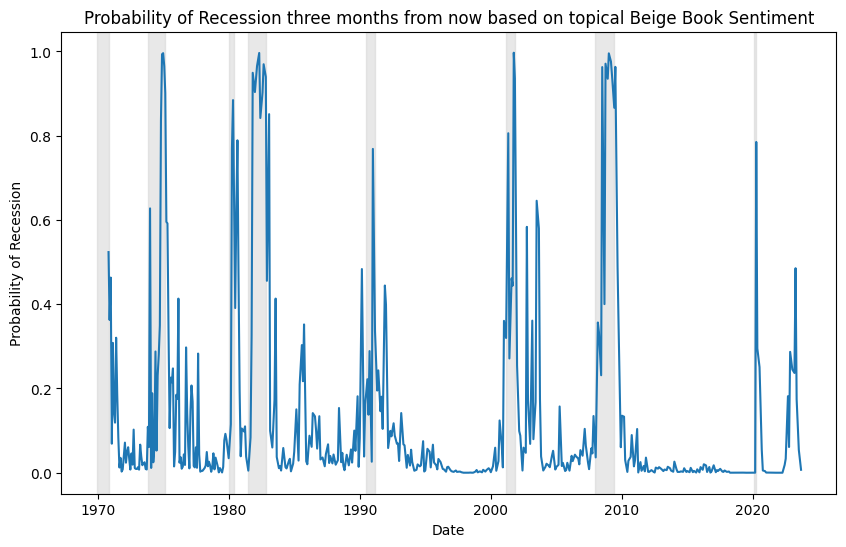

In [67]:
# This recreates Figure 2 from Filippou et al. (2024) but with a 3-month lead
    
# Calculate probabilities from the logit model above
df['Recession_probability'] = model.predict(X)

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Recession_probability'])

# Add recession bars
plt.axvspan("1969-12-01", "1970-11-01", color='lightgray', alpha=0.5)
plt.axvspan("1973-11-01", "1975-03-01", color='lightgray', alpha=0.5)
plt.axvspan("1980-01-01", "1980-06-01", color='lightgray', alpha=0.5)
plt.axvspan("1981-07-01", "1982-11-01", color='lightgray', alpha=0.5)
plt.axvspan("1990-07-01", "1991-03-01", color='lightgray', alpha=0.5)
plt.axvspan("2001-03-01", "2001-11-01", color='lightgray', alpha=0.5)
plt.axvspan("2007-12-01", "2009-06-01", color='lightgray', alpha=0.5)
plt.axvspan("2020-02-01", "2020-04-01", color='lightgray', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Probability of Recession')
plt.title('Probability of Recession three months from now based on topical Beige Book Sentiment')
plt.show()


In [68]:
# This is the same approach as Table 1, column 6 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_6']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.264096
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_6   No. Observations:                  458
Model:                          Logit   Df Residuals:                      444
Method:                           MLE   Df Model:                           13
Date:                Mon, 02 Dec 2024   Pseudo R-squ.:                  0.3595
Time:                        21:03:34   Log-Likelihood:                -120.96
converged:                       True   LL-Null:                       -188.85
Covariance Type:            nonrobust   LLR p-value:                 1.460e-22
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.4669      1.235     -4.426      0.000      -7.888      -3.046
Employment         0.2105      0.058      3.631      0.000       0.097       0.324
Prices             0.0905      0.055      1.634      0.102      -0.018       0.199
Consumption        0.0189      0.042      0.454      0.650      -0.063       0.100
Manufacturing     -0.0665      0.063     -1.055      0.291      -0.190       0.057
Construction      -0.0142      0.035     -0.401      0.689      -0.084       0.055
Lending            0.1212      0.044      2.760      0.006       0.035       0.207
Uncertainty       -0.0261      0.059     -0.444      0.657      -0.141       0.089
Resources         -0.0552      0.059     -0.930      0.352      -0.172       0.061
Transportation    -0.1064      0.105     -1.009      0.313      -0.313       0.100
Outlook            0.0608      0.097      0.625      0.532      -0.130       0.251
Labor             -0.0096      0.053     -0.182      0.856      -0.113       0.094
Capital            0.2970      0.076      3.901      0.000       0.148       0.446
Trade             -0.4976      0.155     -3.206      0.001      -0.802      -0.193
==================================================================================
"""

In [12]:
# This is the same approach as Table 1, column 6 in Filippou et al. (2024): https://www.clevelandfed.org/publications/economic-commentary/2024/ec-202408-regional-economic-sentiment

# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_6']

# Fit the model with a logistic regression
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.249044
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_6   No. Observations:                  448
Model:                         Probit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.3608
Time:                        20:47:16   Log-Likelihood:                -111.57
converged:                       True   LL-Null:                       -174.54
Covariance Type:            nonrobust   LLR p-value:                 1.343e-20
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.5026      0.704     -4.975      0.000      -4.883      -2.123
Employment         0.1034      0.032      3.227      0.001       0.041       0.166
Prices             0.0457      0.031      1.473      0.141      -0.015       0.106
Consumption        0.0160      0.022      0.722      0.470      -0.027       0.060
Manufacturing     -0.0343      0.034     -1.002      0.317      -0.102       0.033
Construction      -0.0095      0.019     -0.491      0.624      -0.047       0.028
Lending            0.0814      0.025      3.270      0.001       0.033       0.130
Uncertainty       -0.0126      0.030     -0.418      0.676      -0.072       0.047
Resources         -0.0023      0.033     -0.070      0.944      -0.067       0.063
Transportation    -0.0061      0.051     -0.120      0.905      -0.106       0.093
Outlook            0.0159      0.055      0.291      0.771      -0.091       0.123
Labor             -0.0222      0.031     -0.704      0.481      -0.084       0.040
Capital            0.1647      0.044      3.725      0.000       0.078       0.251
Trade             -0.2342      0.079     -2.960      0.003      -0.389      -0.079
==================================================================================
"""

In [7]:
# This uses an 8-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_8']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.254450
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_8   No. Observations:                  448
Model:                          Logit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.3469
Time:                        20:37:12   Log-Likelihood:                -113.99
converged:                       True   LL-Null:                       -174.54
Covariance Type:            nonrobust   LLR p-value:                 1.224e-19
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.6177      1.177     -2.224      0.026      -4.925      -0.310
Employment         0.1354      0.056      2.403      0.016       0.025       0.246
Prices             0.0086      0.056      0.153      0.878      -0.102       0.119
Consumption       -0.0657      0.040     -1.627      0.104      -0.145       0.013
Manufacturing     -0.0442      0.062     -0.714      0.475      -0.165       0.077
Construction       0.0242      0.035      0.699      0.485      -0.044       0.092
Lending            0.1008      0.043      2.361      0.018       0.017       0.184
Uncertainty       -0.1275      0.068     -1.863      0.062      -0.262       0.007
Resources         -0.1371      0.066     -2.066      0.039      -0.267      -0.007
Transportation     0.2943      0.077      3.840      0.000       0.144       0.445
Outlook           -0.0119      0.110     -0.108      0.914      -0.227       0.203
Labor             -0.2588      0.077     -3.353      0.001      -0.410      -0.108
Capital            0.2972      0.078      3.803      0.000       0.144       0.450
Trade             -0.2998      0.134     -2.229      0.026      -0.563      -0.036
==================================================================================
"""

In [13]:
# This uses an 8-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_8']

# Fit the model with a logistic regression
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.253688
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:       Recession_lead_8   No. Observations:                  448
Model:                         Probit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.3488
Time:                        20:47:36   Log-Likelihood:                -113.65
converged:                       True   LL-Null:                       -174.54
Covariance Type:            nonrobust   LLR p-value:                 8.969e-20
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7222      0.656     -2.626      0.009      -3.008      -0.437
Employment         0.0720      0.031      2.295      0.022       0.011       0.134
Prices             0.0072      0.031      0.230      0.818      -0.054       0.068
Consumption       -0.0316      0.022     -1.415      0.157      -0.075       0.012
Manufacturing     -0.0273      0.035     -0.788      0.431      -0.095       0.041
Construction       0.0125      0.019      0.648      0.517      -0.025       0.050
Lending            0.0610      0.024      2.585      0.010       0.015       0.107
Uncertainty       -0.0706      0.036     -1.951      0.051      -0.141       0.000
Resources         -0.0722      0.036     -2.020      0.043      -0.142      -0.002
Transportation     0.1557      0.042      3.750      0.000       0.074       0.237
Outlook           -0.0073      0.059     -0.124      0.901      -0.122       0.108
Labor             -0.1315      0.041     -3.242      0.001      -0.211      -0.052
Capital            0.1810      0.045      4.028      0.000       0.093       0.269
Trade             -0.1475      0.067     -2.193      0.028      -0.279      -0.016
==================================================================================
"""

In [8]:
# This uses an 16-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_16']

# Fit the model with a logistic regression
model = sm.Logit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.302526
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Recession_lead_16   No. Observations:                  448
Model:                          Logit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.2763
Time:                        20:37:40   Log-Likelihood:                -135.53
converged:                       True   LL-Null:                       -187.28
Covariance Type:            nonrobust   LLR p-value:                 3.476e-16
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4616      1.037     -0.445      0.656      -2.494       1.571
Employment         0.1233      0.057      2.153      0.031       0.011       0.235
Prices             0.0388      0.049      0.795      0.427      -0.057       0.135
Consumption       -0.1575      0.042     -3.782      0.000      -0.239      -0.076
Manufacturing     -0.0573      0.065     -0.883      0.377      -0.184       0.070
Construction       0.0699      0.032      2.184      0.029       0.007       0.133
Lending            0.0236      0.040      0.583      0.560      -0.056       0.103
Uncertainty        0.0266      0.040      0.666      0.505      -0.052       0.105
Resources         -0.2285      0.063     -3.627      0.000      -0.352      -0.105
Transportation     0.0608      0.077      0.788      0.431      -0.090       0.212
Outlook           -0.1888      0.112     -1.687      0.092      -0.408       0.031
Labor             -0.1889      0.056     -3.381      0.001      -0.298      -0.079
Capital            0.2655      0.075      3.554      0.000       0.119       0.412
Trade              0.0612      0.047      1.312      0.190      -0.030       0.153
==================================================================================
"""

In [14]:
# This uses an 16-period (one-year) lead
# Drop rows with missing values
dfBinary = df.dropna()

# Define X as including all the topic columns
X = dfBinary[topic_columns]
X = sm.add_constant(X)

# Define y as the 6-month lead of the Recession dummy variable
y = dfBinary['Recession_lead_16']

# Fit the model with a logistic regression
model = sm.Probit(y, X).fit()

# Print the summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.308552
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:      Recession_lead_16   No. Observations:                  448
Model:                         Probit   Df Residuals:                      434
Method:                           MLE   Df Model:                           13
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                  0.2619
Time:                        20:47:47   Log-Likelihood:                -138.23
converged:                       True   LL-Null:                       -187.28
Covariance Type:            nonrobust   LLR p-value:                 3.876e-15
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.5042      0.562     -0.897      0.370      -1.606       0.598
Employment         0.0714      0.031      2.284      0.022       0.010       0.133
Prices             0.0257      0.026      0.985      0.324      -0.025       0.077
Consumption       -0.0822      0.022     -3.781      0.000      -0.125      -0.040
Manufacturing     -0.0262      0.034     -0.759      0.448      -0.094       0.041
Construction       0.0337      0.018      1.890      0.059      -0.001       0.069
Lending            0.0137      0.023      0.591      0.555      -0.032       0.059
Uncertainty        0.0180      0.022      0.816      0.414      -0.025       0.061
Resources         -0.1174      0.033     -3.550      0.000      -0.182      -0.053
Transportation     0.0466      0.034      1.366      0.172      -0.020       0.113
Outlook           -0.1237      0.062     -1.992      0.046      -0.245      -0.002
Labor             -0.0841      0.026     -3.178      0.001      -0.136      -0.032
Capital            0.1515      0.041      3.674      0.000       0.071       0.232
Trade              0.0219      0.023      0.947      0.344      -0.023       0.067
==================================================================================
"""

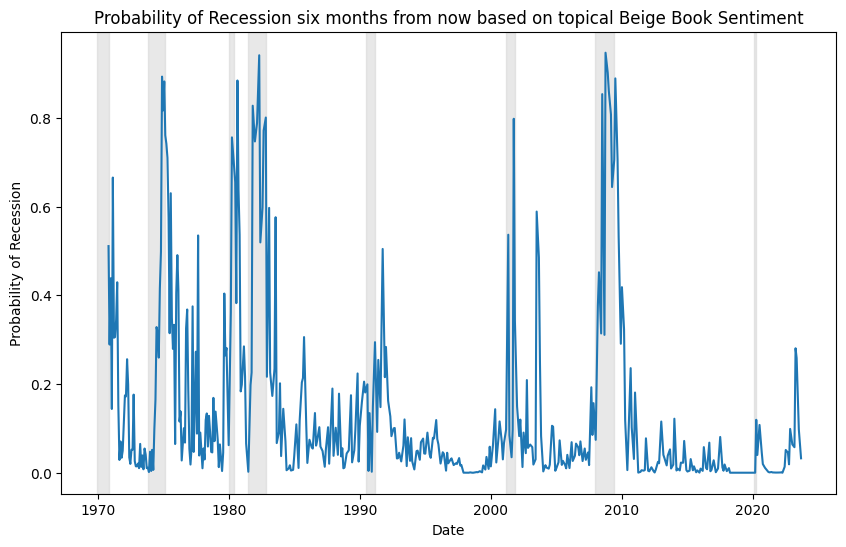

In [70]:
# This recreates Figure 2 from Filippou et al. (2024) but with a 6-month lead
    
# Calculate probabilities from the logit model above
df['Recession_probability'] = model.predict(X)

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['Recession_probability'])

# Add recession bars
plt.axvspan("1969-12-01", "1970-11-01", color='lightgray', alpha=0.5)
plt.axvspan("1973-11-01", "1975-03-01", color='lightgray', alpha=0.5)
plt.axvspan("1980-01-01", "1980-06-01", color='lightgray', alpha=0.5)
plt.axvspan("1981-07-01", "1982-11-01", color='lightgray', alpha=0.5)
plt.axvspan("1990-07-01", "1991-03-01", color='lightgray', alpha=0.5)
plt.axvspan("2001-03-01", "2001-11-01", color='lightgray', alpha=0.5)
plt.axvspan("2007-12-01", "2009-06-01", color='lightgray', alpha=0.5)
plt.axvspan("2020-02-01", "2020-04-01", color='lightgray', alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Probability of Recession')
plt.title('Probability of Recession six months from now based on topical Beige Book Sentiment')
plt.show()


In [ ]:
# Create df with just DATE and Recession_probability
df_recession_probability = df[["DATE", "Recession_probability"]]
#df_recession_probability.to_csv("recession_probability_in_six_months.csv", index=False)